In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/PSA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,146.580002,146.580002,144.800003,146.089996,113.703110,636300
1,1/3/2013,145.990005,146.960007,145.300003,145.550003,113.282799,568600
2,1/4/2013,145.410004,146.410004,145.169998,146.220001,113.804298,444100
3,1/7/2013,145.850006,146.630005,145.679993,145.949997,113.594132,442300
4,1/8/2013,145.880005,146.020004,144.350006,144.960007,112.823608,446000


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 4171.449967.3, cost: -2000.919189, total money: 759.569962
epoch: 20, total rewards: 4241.159974.3, cost: -3089.563232, total money: 1051.500001
epoch: 30, total rewards: 3918.459977.3, cost: -5980.043945, total money: 1833.100007
epoch: 40, total rewards: 1878.080047.3, cost: -10782.040039, total money: 1721.890090
epoch: 50, total rewards: 15.640045.3, cost: -13799.408203, total money: 2083.820022
epoch: 60, total rewards: 907.140014.3, cost: -12369.295898, total money: 2081.289993
epoch: 70, total rewards: 1920.119964.3, cost: -10830.104492, total money: 1710.139938
epoch: 80, total rewards: 973.380035.3, cost: -13686.990234, total money: 2052.839997
epoch: 90, total rewards: 644.760071.3, cost: -15086.505859, total money: 2759.980042
epoch: 100, total rewards: 748.320099.3, cost: -14511.881836, total money: 2652.190064
epoch: 110, total rewards: -88.249938.3, cost: -18051.488281, total money: 3794.350068
epoch: 120, total rewards: 208.750184.3, cost: -1685

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 146.220001, total balance 9853.779999
day 3, sell 1 unit at price 145.949997, investment -0.184656 %, total balance 9999.729996,
day 5: buy 1 unit at price 145.490005, total balance 9854.239990
day 6, sell 1 unit at price 146.279999, investment 0.542988 %, total balance 10000.519989,
day 7: buy 1 unit at price 147.050003, total balance 9853.469986
day 8, sell 1 unit at price 146.309998, investment -0.503234 %, total balance 9999.779984,
day 9: buy 1 unit at price 147.669998, total balance 9852.109985
day 10, sell 1 unit at price 147.960007, investment 0.196390 %, total balance 10000.069992,
day 15: buy 1 unit at price 151.729996, total balance 9848.339996
day 16: buy 1 unit at price 152.699997, total balance 9695.639999
day 17: buy 1 unit at price 153.440002, total balance 9542.199997
day 20: buy 1 unit at price 153.929993, total balance 9388.270004
day 21: buy 1 unit at price 155.500000, total balance 9232.770004
day 23: buy 1 unit at price 156.940002, total

day 302, sell 1 unit at price 168.100006, investment 8.795555 %, total balance 8609.359940,
day 305: buy 1 unit at price 167.589996, total balance 8441.769944
day 306, sell 1 unit at price 169.360001, investment 7.468751 %, total balance 8611.129944,
day 307: buy 1 unit at price 167.899994, total balance 8443.229950
day 308: buy 1 unit at price 168.880005, total balance 8274.349945
day 309, sell 1 unit at price 167.830002, investment 7.679970 %, total balance 8442.179947,
day 310, sell 1 unit at price 167.589996, investment 5.688332 %, total balance 8609.769944,
day 311, sell 1 unit at price 168.029999, investment 2.764360 %, total balance 8777.799942,
day 313, sell 1 unit at price 169.490005, investment 1.545744 %, total balance 8947.289948,
day 314, sell 1 unit at price 169.949997, investment 1.365855 %, total balance 9117.239945,
day 315: buy 1 unit at price 169.320007, total balance 8947.919937
day 317, sell 1 unit at price 169.779999, investment 1.597749 %, total balance 9117.6999

day 467, sell 1 unit at price 186.289993, investment 7.931626 %, total balance 7408.669998,
day 468: buy 1 unit at price 188.119995, total balance 7220.550003
day 469, sell 1 unit at price 187.350006, investment 9.446205 %, total balance 7407.900009,
day 472, sell 1 unit at price 185.619995, investment 11.765410 %, total balance 7593.520004,
day 473: buy 1 unit at price 186.199997, total balance 7407.320008
day 474, sell 1 unit at price 186.460007, investment 11.539157 %, total balance 7593.780014,
day 475: buy 1 unit at price 183.919998, total balance 7409.860016
day 476, sell 1 unit at price 183.979996, investment 11.421997 %, total balance 7593.840012,
day 478: buy 1 unit at price 185.179993, total balance 7408.660019
day 479: buy 1 unit at price 185.399994, total balance 7223.260025
day 481: buy 1 unit at price 187.630005, total balance 7035.630020
day 482: buy 1 unit at price 186.259995, total balance 6849.370026
day 484, sell 1 unit at price 186.130005, investment 12.833413 %, to

day 642, sell 1 unit at price 201.490005, investment 1.190242 %, total balance 4705.009995,
day 643: buy 1 unit at price 201.100006, total balance 4503.909988
day 644, sell 1 unit at price 201.929993, investment 1.278959 %, total balance 4705.839981,
day 645, sell 1 unit at price 202.919998, investment 2.754711 %, total balance 4908.759979,
day 649, sell 1 unit at price 205.179993, investment 5.692056 %, total balance 5113.939972,
day 650: buy 1 unit at price 205.520004, total balance 4908.419968
day 653: buy 1 unit at price 207.490005, total balance 4700.929962
day 655, sell 1 unit at price 207.449997, investment 7.104133 %, total balance 4908.379959,
day 657: buy 1 unit at price 210.529999, total balance 4697.849960
day 658, sell 1 unit at price 212.550003, investment 11.311865 %, total balance 4910.399963,
day 659: buy 1 unit at price 213.729996, total balance 4696.669968
day 660, sell 1 unit at price 215.350006, investment 12.372160 %, total balance 4912.019974,
day 662: buy 1 unit

day 837, sell 1 unit at price 244.809998, investment 1.940455 %, total balance 4266.529984,
day 838, sell 1 unit at price 252.570007, investment 6.646120 %, total balance 4519.099991,
day 840: buy 1 unit at price 257.480011, total balance 4261.619980
day 841, sell 1 unit at price 260.059998, investment 5.629570 %, total balance 4521.679978,
day 842, sell 1 unit at price 263.309998, investment 8.819274 %, total balance 4784.989975,
day 843, sell 1 unit at price 264.779999, investment 7.280905 %, total balance 5049.769974,
day 844, sell 1 unit at price 264.940002, investment 5.482344 %, total balance 5314.709977,
day 845: buy 1 unit at price 259.279999, total balance 5055.429978
day 847: buy 1 unit at price 261.890015, total balance 4793.539963
day 848: buy 1 unit at price 264.970001, total balance 4528.569962
day 849, sell 1 unit at price 258.239990, investment 5.675818 %, total balance 4786.809952,
day 850, sell 1 unit at price 253.820007, investment 2.120299 %, total balance 5040.6299

day 1004, sell 1 unit at price 220.139999, investment -7.744529 %, total balance 4433.319962,
day 1005, sell 1 unit at price 218.279999, investment -8.657992 %, total balance 4651.599961,
day 1006: buy 1 unit at price 220.399994, total balance 4431.199967
day 1007: buy 1 unit at price 223.500000, total balance 4207.699967
day 1008, sell 1 unit at price 223.520004, investment -3.969750 %, total balance 4431.219971,
day 1009, sell 1 unit at price 225.160004, investment -3.061093 %, total balance 4656.379975,
day 1010: buy 1 unit at price 227.559998, total balance 4428.819977
day 1011: buy 1 unit at price 228.350006, total balance 4200.469971
day 1012: buy 1 unit at price 226.789993, total balance 3973.679978
day 1013: buy 1 unit at price 225.300003, total balance 3748.379975
day 1014: buy 1 unit at price 219.759995, total balance 3528.619980
day 1015, sell 1 unit at price 217.300003, investment -4.500303 %, total balance 3745.919984,
day 1016, sell 1 unit at price 214.119995, investment 

day 1182: buy 1 unit at price 207.580002, total balance 4410.039918
day 1184, sell 1 unit at price 212.559998, investment 2.157923 %, total balance 4622.599915,
day 1188, sell 1 unit at price 214.110001, investment 2.705425 %, total balance 4836.709916,
day 1189, sell 1 unit at price 214.869995, investment -1.240985 %, total balance 5051.579911,
day 1190, sell 1 unit at price 213.710007, investment -0.298577 %, total balance 5265.289918,
day 1191: buy 1 unit at price 214.210007, total balance 5051.079911
day 1193, sell 1 unit at price 211.979996, investment -1.564899 %, total balance 5263.059907,
day 1195, sell 1 unit at price 213.990005, investment 1.249113 %, total balance 5477.049912,
day 1196, sell 1 unit at price 214.279999, investment 1.597836 %, total balance 5691.329911,
day 1197: buy 1 unit at price 212.919998, total balance 5478.409913
day 1198: buy 1 unit at price 213.869995, total balance 5264.539918
day 1199: buy 1 unit at price 213.679993, total balance 5050.859925
day 12

day 1358, sell 1 unit at price 207.139999, investment -1.022553 %, total balance 3234.109941,
day 1359: buy 1 unit at price 208.490005, total balance 3025.619935
day 1360: buy 1 unit at price 209.850006, total balance 2815.769929
day 1361, sell 1 unit at price 212.229996, investment 1.545452 %, total balance 3027.999925,
day 1362, sell 1 unit at price 211.839996, investment 4.912836 %, total balance 3239.839921,
day 1364, sell 1 unit at price 214.050003, investment 5.168773 %, total balance 3453.889924,
day 1365, sell 1 unit at price 212.880005, investment 10.157829 %, total balance 3666.769929,
day 1366: buy 1 unit at price 213.600006, total balance 3453.169923
day 1367: buy 1 unit at price 215.139999, total balance 3238.029923
day 1368: buy 1 unit at price 216.550003, total balance 3021.479920
day 1369, sell 1 unit at price 216.639999, investment 11.796883 %, total balance 3238.119920,
day 1370: buy 1 unit at price 215.919998, total balance 3022.199922
day 1371: buy 1 unit at price 2

day 1532, sell 1 unit at price 209.179993, investment -8.909601 %, total balance 1885.559877,
day 1533, sell 1 unit at price 208.979996, investment -8.949115 %, total balance 2094.539872,
day 1537, sell 1 unit at price 210.509995, investment -7.703441 %, total balance 2305.049867,
day 1538: buy 1 unit at price 207.740005, total balance 2097.309861
day 1539: buy 1 unit at price 207.960007, total balance 1889.349855
day 1540: buy 1 unit at price 208.149994, total balance 1681.199861
day 1541: buy 1 unit at price 207.740005, total balance 1473.459855
day 1542: buy 1 unit at price 207.910004, total balance 1265.549852
day 1543, sell 1 unit at price 205.619995, investment -6.395959 %, total balance 1471.169847,
day 1544: buy 1 unit at price 200.479996, total balance 1270.689851
day 1546, sell 1 unit at price 201.410004, investment -6.102562 %, total balance 1472.099855,
day 1548, sell 1 unit at price 209.610001, investment -3.773585 %, total balance 1681.709855,
day 1550, sell 1 unit at pri

day 1709, sell 1 unit at price 242.050003, investment 9.026625 %, total balance 2857.729845,
day 1711: buy 1 unit at price 241.550003, total balance 2616.179841
day 1712, sell 1 unit at price 243.789993, investment 9.662182 %, total balance 2859.969835,
day 1713, sell 1 unit at price 240.539993, investment 5.638997 %, total balance 3100.509828,
day 1714: buy 1 unit at price 240.419998, total balance 2860.089830
day 1715: buy 1 unit at price 241.369995, total balance 2618.719835
day 1717: buy 1 unit at price 232.600006, total balance 2386.119829
day 1718: buy 1 unit at price 234.699997, total balance 2151.419832
day 1721, sell 1 unit at price 219.259995, investment -6.471014 %, total balance 2370.679826,
day 1722: buy 1 unit at price 216.119995, total balance 2154.559831
day 1723, sell 1 unit at price 215.270004, investment -8.872705 %, total balance 2369.829835,
day 1724, sell 1 unit at price 214.490005, investment -8.050756 %, total balance 2584.319841,
day 1725: buy 1 unit at price 2

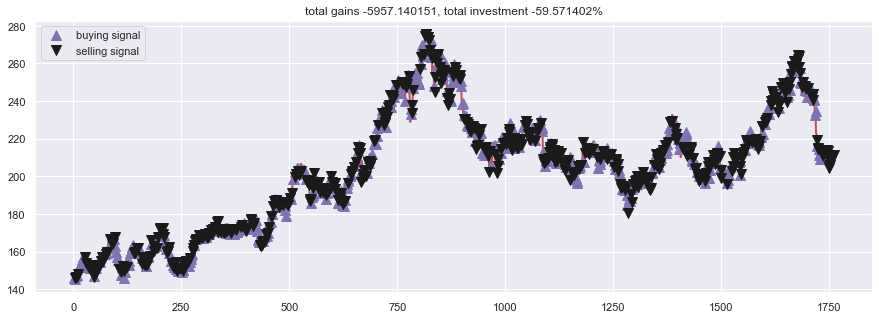

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()